# Image Slice inferencing
Testing image slice inferenceing for microservice setup

# 1) Imports and mount

In [40]:
%load_ext autoreload
%autoreload 2

# This sets up the appropriate logging and path configs
from notebook_setup import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import torch
from torchsummary import summary
import matplotlib.pyplot as plt

from monai.losses import DiceLoss
from src.features.build_features import train_transform, val_transform, test_transform

from src.visualization.visualize import view_slice

from monai.data import Dataset, DataLoader
from src.enums import DataDict

from src.settings.config import get_app_settings
from src.utils import load_yaml

## 2) Import Settings

In [42]:
settings = get_app_settings()
model_config = load_yaml("model_configs.yaml")

## 3) Inference



### 3.1) Infernce on volume nii

In [ ]:

from src.pytorch_utils import slice_tensor_volume

In [167]:
from src.pytorch_utils import normalize_img_intensity_range, slice_tensor_volume
from monai.transforms import (
    Compose,
    ToTensord,
    LoadImaged,
    EnsureChannelFirstd,
    ToMetaTensord,
    Spacingd,
    Resized,
    Orientationd,
)
from src.features.transforms import ImagesToMultiChannel
from src.models.predict_model import ImagePredictor
from src.models.train_model import model

serving_transform = Compose(
    [
        # ToMetaTensord(keys=[DataDict.ImageT1, DataDict.ImageFlair]),
        EnsureChannelFirstd(
            keys=[DataDict.ImageT1, DataDict.ImageFlair], 
            channel_dim="no_channel"
        ),
        Spacingd(
            keys=[DataDict.ImageT1, DataDict.ImageFlair],
            pixdim=(1.5, 1.5),
            mode=("bilinear", "bilinear"),
            # pixdim=(1.5, 1.5, 2.0),
            # mode=("bilinear", "bilinear", "nearest"),
        ),
        Resized(
            keys=[DataDict.ImageT1, DataDict.ImageFlair],
            spatial_size=[256, 256],
        ),
        Orientationd(keys=[DataDict.ImageT1, DataDict.ImageFlair], axcodes="RAS"),
        ToTensord(keys=[DataDict.ImageT1, DataDict.ImageFlair]),
        ImagesToMultiChannel(keys=[DataDict.ImageT1, DataDict.ImageFlair]),
    ]
)

def segment(t1, flair):
    t1 = normalize_img_intensity_range(t1)
    flair = normalize_img_intensity_range(flair)
    
    t1_slices = slice_tensor_volume(t1)
    flair_slices = slice_tensor_volume(flair)
    inference_dict = [{
        DataDict.Id: -1,
        DataDict.ImageT1: v,
        DataDict.ImageFlair: flair_slices.get(idx),
        DataDict.DepthZ: idx,
    } for idx, v in t1_slices.items()]

    pred_network = model
    checkpoint = torch.load(
        "models/single_slice_t1_flair_v1.pt", map_location=torch.device("cpu")
    )
    pred_network.load_state_dict(checkpoint["model_state_dict"])
    test_dataset = Dataset(inference_dict, serving_transform)
    img_predictor = ImagePredictor(pred_network, test_dataset)
    test_predictions = img_predictor.predict_handler()
    return {
        DataDict.Prediction: test_predictions[0][DataDict.Prediction],
    }

[autoreload of src.features.build_features failed: Traceback (most recent call last):
  File "c:\Users\zifen\Documents\Projects\wmh-segmentation\venv\Lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\zifen\Documents\Projects\wmh-segmentation\venv\Lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "C:\Python311\Lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "c:\Users\zifen\Documents\Projects\wmh-segmentation\src\features\build_features.py", line 19, in <module>
    from src.features.transforms import (
ImportError: cannot import name 'CustomTransform' from 'src.feat

In [172]:

from src.data.make_dataset import get_test_raw_paths
from copy import copy
import nibabel as nib

raw_test_paths = get_test_raw_paths()
sample_inference_images = copy(raw_test_paths[0])

t1 = nib.load(sample_inference_images[DataDict.ImageT1]).get_fdata()
flair = nib.load(sample_inference_images[DataDict.ImageFlair]).get_fdata()

pred_dict = segment(t1, flair)

c:\Users\zifen\Documents\Projects\wmh-segmentation\venv\Lib\site-packages\monai\transforms\spatial\array.py:635: UserWarning: axcodes ('RAS') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (256, 256), channels = 1,please make sure the input is in the channel-first format.
  warnings.warn(
c:\Users\zifen\Documents\Projects\wmh-segmentation\venv\Lib\site-packages\torch\_tensor.py:1386: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ret = func(*args, **kwargs)


Predicting 1/48 slices
Predicting 48/48 slices
1 subjects to predict
Reconstructing 1/1


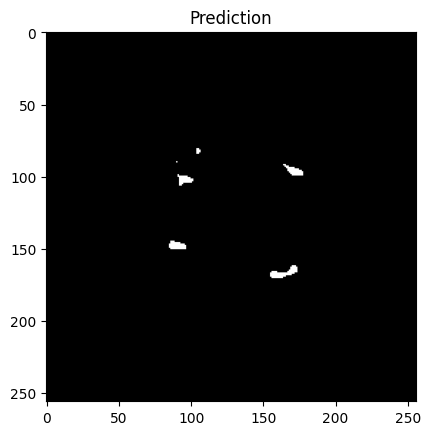

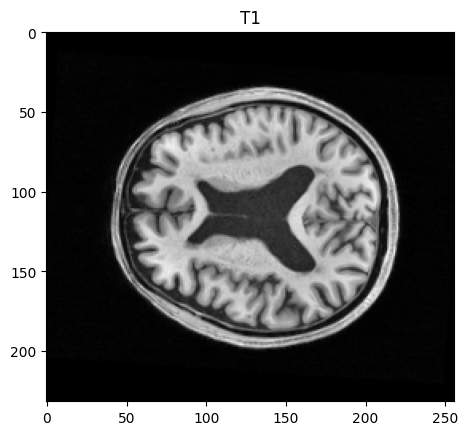

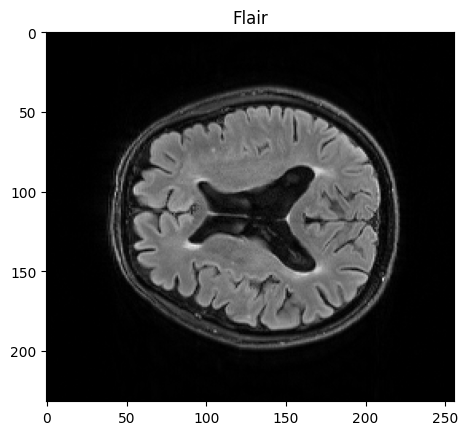

In [173]:
z_depth = 25
view_slice(pred_dict[DataDict.Prediction][..., z_depth], "Prediction", True)
view_slice(t1[..., z_depth], "T1", True)
view_slice(flair[..., z_depth], "Flair", True)